## Define graph

We will be using a single-node graph that calls a [chat model](https://python.langchain.com/docs/concepts/#chat-models).

Let's first define the model we'll be using:

In [4]:
from langchain_openai import ChatOpenAI
from langfuse.callback import CallbackHandler
from langgraph.graph import StateGraph, MessagesState, START
from IPython.display import display, Image

from typing import Annotated
from typing_extensions import TypedDict


llm = ChatOpenAI(model = "gpt-4o-mini", temperature = 0.2)
langfuse_handler = CallbackHandler()

Now we can define our `StateGraph` and add our model-calling node:

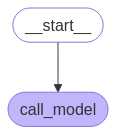

In [5]:

def call_model(state: MessagesState):
    response = llm.invoke(state["messages"])
    return {"messages": response}


builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_edge(START, "call_model")
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

If we try to use this graph, the context of the conversation will not be persisted across interactions:

In [ ]:
input_message = {"role": "user", "content": "hi! I'm bob"}
for chunk in graph.stream({"messages": [input_message]}, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

input_message = {"role": "user", "content": "what's my name?"}
for chunk in graph.stream({"messages": [input_message]}, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

hi! I'm bob
================================== Ai Message ==================================

Hi Bob! How can I assist you today?
================================ Human Message =================================

what's my name?
================================== Ai Message ==================================

I'm sorry, but I don't have access to personal information about you unless you share it with me. How can I assist you today?


## Add persistence

To add in persistence, we need to pass in a [Checkpointer](https://langchain-ai.github.io/langgraph/reference/checkpoints/#langgraph.checkpoint.base.BaseCheckpointSaver) when compiling the graph.

In [9]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

We can now interact with the agent and see that it remembers previous messages!

In [10]:
config = {"configurable": {"thread_id": "1"}}
input_message = {"role": "user", "content": "hi! I'm bob"}
for chunk in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

hi! I'm bob
================================== Ai Message ==================================

Hi Bob! How can I assist you today?


You can always resume previous threads:

In [11]:
input_message = {"role": "user", "content": "what's my name?"}
for chunk in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

what's my name?
================================== Ai Message ==================================

Your name is Bob! How can I help you today?


If we want to start a new conversation, we can pass in a different `thread_id`. Poof! All the memories are gone!

In [12]:
input_message = {"role": "user", "content": "what's my name?"}
for chunk in graph.stream(
    {"messages": [input_message]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

what's my name?
================================== Ai Message ==================================

I'm sorry, but I don't have access to personal information about you unless you've shared it in this conversation. How can I assist you today?
